#### Dataset
* https://www.kaggle.com/datasets/lacofloris/type-1-diabetes-blood-glucose-prediction
* Custom log data range: Jan 2 2022 - Apr 25 2022 (a note in author's notebook indicates that 2022/01/09 00:00 is the start date for recording insulin and carbs here, as opposed to using data from glucose meter)
* Fitbit activity data range: Dec 28 2021 - Apr 26 2022
* Glucose meter data range: Dec 21 2021 - Apr 25 2022 (later exports still contain earlier data...)
* Start / end dates may not include full day
* Use range from Jan 9 2022 to Apr 24 2022

##### Some ideas of what models to use
* Time intervals of non-glucose data are irregular / large
* Resampling glucose data so it matches these large intervals would obliterate the kind of granularity of glucose level development required to be forecasted
* Model must accomodate irregular time intervals
    - machine learning models for time series analysis: Long Short-Term Memory (LSTM) and Extreme Gradient Boosting (XGBoost)
    - state space models: regular (frequentist) and Bayesian (BSTS)

In [276]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.arima.model import ARIMA
import itertools

##### Set date range

In [277]:
start_date = pd.to_datetime('2022-01-09')
end_date = pd.to_datetime('2022-04-24')

#### Load Fitbit Data
* Heartrate is the least 'derivative' data. However, during swims Fitbit may not track heartrate. Otherwise, 6 or 7 measurements per minute.
* Active Minutes is the most comprehensive activity measure. Four categories, only daily sums.
* Step Count is not derivative and considered comprehensive together with Active Minutes, but can be misleading if bulk of activity is something other than walking and combined with sedentary job -> leave out for now.
* Sleep data: sleep impacts on stress level, which in turn influences blood glucose -> may add later.

In [278]:
def read_activity(level):
    # get all json files for this activity level
    folder_path = "../data/raw"
    json_files = [file for file in os.listdir(folder_path) if file.endswith(".json") and level in file]

    # read each file into a DataFrame
    activity = []
    for json_file in json_files:
        file_path = os.path.join(folder_path, json_file)
        df = pd.read_json(file_path)
        activity.append(df)

    # combine into a single DataFrame
    df = pd.concat(activity)
    return df.rename(columns={'value': level + '_mins'})

In [279]:
def limit_range(df, datetime_col):
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    return df[(df[datetime_col] >= start_date) & (df[datetime_col] <= end_date)]

In [280]:
# combine all activity levels into a single DataFrame
# note: only works because different types have exactly the same date ranges
df_activity = pd.concat([read_activity(l) for l in ['sedentary', 'lightly', 'moderately', 'very']], axis=1)
# assert(df_activity.iloc[:, 4] == df_activity.iloc[:, 6]).all()

# remove duplicate dateTime columns
df_activity = df_activity.iloc[:, [0, 1, 3, 5, 7]]

# limit to date range
df_activity = limit_range(df_activity, 'dateTime')

df_activity.head()

,dateTime,sedentary_mins,lightly_mins,moderately_mins,very_mins
12,2022-01-09,591,251,21,24
13,2022-01-10,689,283,18,21
14,2022-01-11,635,228,8,12
15,2022-01-12,577,350,27,32
16,2022-01-13,698,251,16,23


In [281]:
# TODO: load heartrate

#### Load Glucose Monitor Data

In [282]:
# TODO: factor both reader methods into one
def read_glucose():
  # get all csv files with 'export' in name
    folder_path = "../data/raw"
    csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv") and 'export' in file]

    # read each file into a DataFrame
    glucose = []
    for json_file in csv_files:
        file_path = os.path.join(folder_path, json_file)
        # limit to columns containing variables with clear meaning that are not covered in other files; historic: 15 min ave.
        df = pd.read_csv(file_path, sep='\t', usecols=['Time', 'Historic Glucose (mmol/L)', 'Scan Glucose (mmol/L)', 'Strip Glucose (mmol/L)'])
        glucose.append(df)

    # combine into a single DataFrame
    return pd.concat(glucose)

In [283]:
df_glucose = read_glucose()

# shorten and unify column names
df_glucose.rename(columns= {'Time': 'dateTime', 'Historic Glucose (mmol/L)': 'hist_gluc', 'Scan Glucose (mmol/L)': 'scan_gluc', 'Strip Glucose (mmol/L)': 'strip_gluc'}, inplace=True)

# limit to date range
df_glucose = limit_range(df_glucose, 'dateTime')

# drop rows that don't have any glucose data
df_glucose.dropna(how='all', subset=['hist_gluc', 'scan_gluc', 'strip_gluc'], inplace=True)

# drop rows that are exact duplicates
df_glucose.drop_duplicates(keep='first', inplace=True)

# check for dateTime duplicate entries
print("dateTime duplicates:\n", df_glucose.duplicated(subset=['dateTime'], keep=False).value_counts())

df_glucose.head()

dateTime duplicates:
 False    14469
True       710
Name: count, dtype: int64


,dateTime,hist_gluc,scan_gluc,strip_gluc
1253,2022-01-09 00:26:00,NaN,8.2,NaN
1254,2022-01-09 00:34:00,NaN,8.3,NaN
1255,2022-01-09 00:50:00,NaN,8.6,NaN
1256,2022-01-09 01:02:00,NaN,10.2,NaN
1257,2022-01-09 01:08:00,NaN,9.9,NaN


In [284]:
# check how much data each column has
df_glucose.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15179 entries, 1253 to 5470
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dateTime    15179 non-null  datetime64[ns]
 1   hist_gluc   9789 non-null   float64       
 2   scan_gluc   5340 non-null   float64       
 3   strip_gluc  50 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 592.9 KB


In [285]:
# remove column with few values
df_glucose.drop(columns=['strip_gluc'], inplace=True)

# drop rows that are left with all NaN
df_glucose.dropna(how='all', subset=['hist_gluc', 'scan_gluc'], inplace=True)

# check for dateTime duplicates
print("dateTime duplicates:\n", df_glucose.duplicated(subset=['dateTime'], keep=False).value_counts())

dateTime duplicates:
 False    14429
True       700
Name: count, dtype: int64


In [286]:
# take a look at duplicte dateTime
df_mask = df_glucose.duplicated(subset=['dateTime'], keep=False)
df_dups = df_glucose[df_mask].sort_values(by='dateTime')
print('unique dateTime dups:', df_dups.dateTime.nunique())
df_dups.head(10)

unique dateTime dups: 350


,dateTime,hist_gluc,scan_gluc
1253,2022-01-09 00:26:00,NaN,8.2
10794,2022-01-09 00:26:00,7.9,NaN
1270,2022-01-09 12:13:00,NaN,8.4
10841,2022-01-09 12:13:00,8.3,NaN
1305,2022-01-09 20:28:00,NaN,7.6
10874,2022-01-09 20:28:00,7.5,NaN
1326,2022-01-10 01:28:00,NaN,9.8
10894,2022-01-10 01:28:00,9.9,NaN
1719,2022-01-10 13:47:00,8.2,NaN
1342,2022-01-10 13:47:00,NaN,8.4


In [287]:
# every duplicate date occurs exactly twice: Group by 'datetime' and collate
df_glucose = df_glucose.groupby(['dateTime'],as_index=False).first()

# check for dateTime duplicates
print("dateTime duplicates:\n", df_glucose.duplicated(subset=['dateTime']).value_counts())

dateTime duplicates:
 False    14779
Name: count, dtype: int64


In [288]:
df_glucose.set_index('dateTime', inplace=True)
df_glucose.head()

,hist_gluc,scan_gluc
dateTime,,
2022-01-09 00:11:00,7.4,NaN
2022-01-09 00:26:00,7.9,8.2
2022-01-09 00:34:00,NaN,8.3
2022-01-09 00:41:00,8.5,NaN
2022-01-09 00:50:00,NaN,8.6


#### Load Custom Log Data

In [289]:
# load only columns considered relevant by author of data
df_insu_carbs = pd.read_csv('../data/raw/custom_log_2022_01_09-2022_04_25.csv', usecols=['Date', 'Time', 'Tags', 'Basal Injection Units', 'Insulin (Meal)', 'Insulin (Correction)', 'Meal Carbohydrates (Grams, Factor 1)', 'Meal Descriptions', 'Food type'])

# shorten column names
df_insu_carbs.rename(columns={'Basal Injection Units': 'basal_insu', 'Insulin (Meal)': 'meal_insu', 'Insulin (Correction)': 'corr_insu', 'Meal Carbohydrates (Grams, Factor 1)': 'carb_grams', 'Meal Descriptions': 'glyc_index', 'Food type': 'meal_type'}, inplace=True)

# combine meal and 'correction' insulin into one column
df_insu_carbs["rapid_insu"] = df_insu_carbs[["meal_insu", "corr_insu"]].apply(
        lambda x: x["corr_insu"] if np.isnan(x["meal_insu"]) else x["meal_insu"], axis=1
    )

# combine Date and Time into one column, sort 
df_insu_carbs["dateTime"] = pd.to_datetime(df_insu_carbs["Date"] + " " + df_insu_carbs["Time"], format="%b %d, %Y %I:%M:%S %p")
df_insu_carbs.sort_values(by='dateTime', inplace=True)

# drop original columns
df_insu_carbs.drop(columns=['meal_insu', 'corr_insu', 'Date', 'Time'], inplace=True)

# limit date range
df_insu_carbs = limit_range(df_insu_carbs, 'dateTime')

# re-order columns
order = ['dateTime', 'basal_insu', 'rapid_insu', 'carb_grams', 'glyc_index', 'meal_type', 'Tags']
df_insu_carbs = df_insu_carbs.reindex(columns=order)

df_insu_carbs.head()

,dateTime,basal_insu,rapid_insu,carb_grams,glyc_index,meal_type,Tags
1785,2022-01-09 12:11:29,NaN,8.0,40.0,Medium,NaN,Lunch
1784,2022-01-09 12:31:29,NaN,NaN,9.0,Very High,Sweets & snacks,Correction
1783,2022-01-09 15:41:39,NaN,NaN,11.0,Medium,NaN,NaN
1782,2022-01-09 16:22:41,NaN,1.0,NaN,NaN,NaN,NaN
1781,2022-01-09 17:02:05,NaN,1.0,NaN,NaN,NaN,NaN


#### EDA

##### Glucose over entire date range

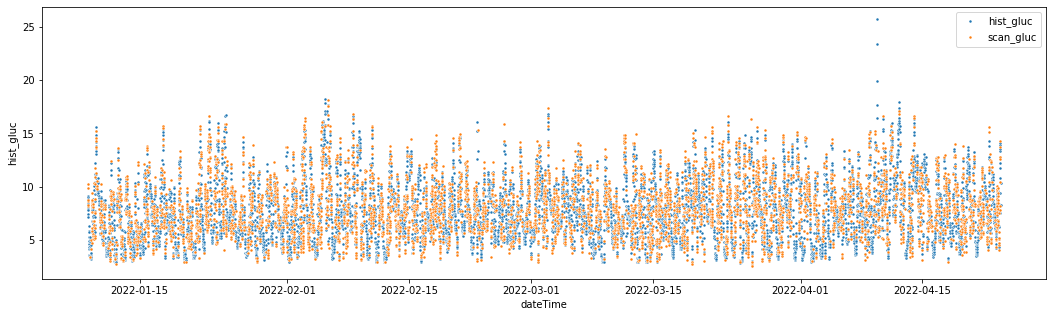

In [290]:
plt.figure(figsize=(18, 5))
sns.scatterplot(x='dateTime', y='hist_gluc', data=df_glucose, label='hist_gluc', marker='.');
sns.scatterplot(x='dateTime', y='scan_gluc', data=df_glucose, label='scan_gluc', marker='.');

##### Zoom in to see if hist_gluc and scan_gluc can be combined

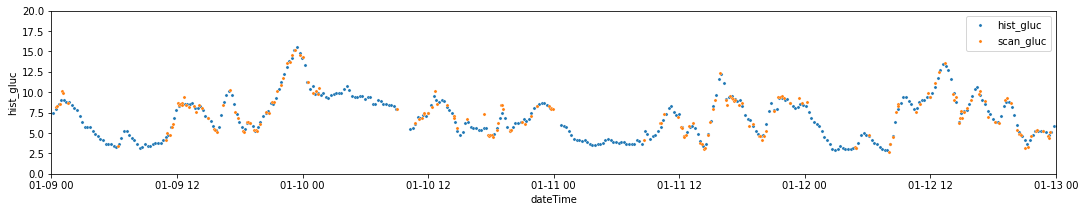

In [291]:
plt.figure(figsize=(18, 3))
ax = sns.scatterplot(data=df_glucose, x='dateTime', y='hist_gluc', label='hist_gluc', s=10)
sns.scatterplot(data=df_glucose, x='dateTime', y='scan_gluc', label='scan_gluc', s=10)
ax.set_xlim(start_date, pd.to_datetime('2022-01-13'))
ax.set_ylim(0,20)
plt.show()

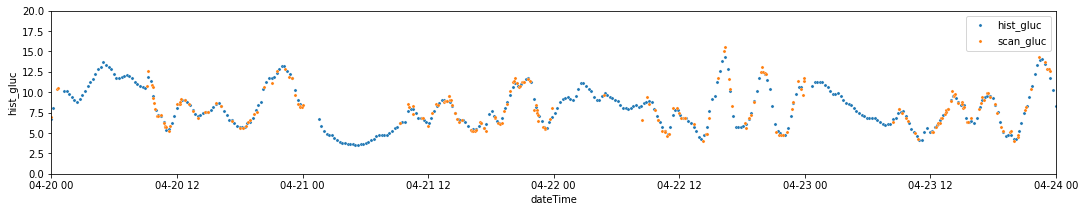

In [292]:
plt.figure(figsize=(18, 3))
ax = sns.scatterplot(data=df_glucose, x='dateTime', y='hist_gluc', label='hist_gluc', s=10)
sns.scatterplot(data=df_glucose, x='dateTime', y='scan_gluc', label='scan_gluc', s=10)
ax.set_xlim(pd.to_datetime('2022-04-20'), end_date)
ax.set_ylim(0,20)
plt.show()

##### Combine glucose data
Data points from glucose measured by a single scan match those of averaged glucose (over 15 minutes according to author). Combine hist_gluc and scan_gluc into one column, using hist_gluc if both are available for the same dateTime.

In [293]:
# combine hist and scan glucose, using hist if both exist
df_glucose['comb_gluc'] = df_glucose['hist_gluc'].combine_first(df_glucose['scan_gluc'])
df_glucose.head()

,hist_gluc,scan_gluc,comb_gluc
dateTime,,,
2022-01-09 00:11:00,7.4,NaN,7.4
2022-01-09 00:26:00,7.9,8.2,7.9
2022-01-09 00:34:00,NaN,8.3,8.3
2022-01-09 00:41:00,8.5,NaN,8.5
2022-01-09 00:50:00,NaN,8.6,8.6


##### Find the best re-sample rate and fill strategy

maximum time gap between two glucose measurements: 0 days 02:52:00
count                        14778
mean     0 days 00:10:13.832724319
std      0 days 00:06:23.751098891
min                0 days 00:01:00
25%                0 days 00:05:00
50%                0 days 00:11:00
75%                0 days 00:15:00
max                0 days 02:52:00
Name: dateTime, dtype: object


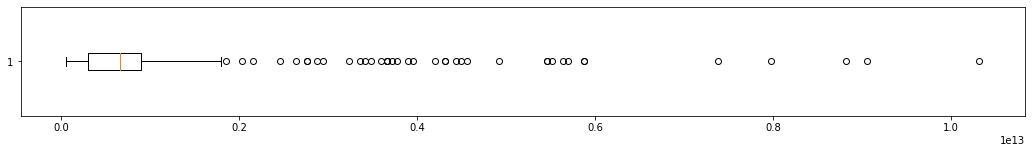

In [294]:
# find biggest gap
max_gap = df_glucose.index.to_series().diff().max()
print('maximum time gap between two glucose measurements:', max_gap)
time_intervals = df_glucose.index.to_series().diff().dropna()
# get stats on gaps
print(time_intervals.describe())
# make box plot of all gap times
plt.figure(figsize=(18, 2))
plt.boxplot(time_intervals, vert=False, showfliers=True)
plt.show()

Note: extreme outliers not included in boxplot, despite showfliers=True.

In [295]:
# use try & error (re-run cell) to find a good cutoff that leaves sample rate less than half an hour
percentile_gap = time_intervals.quantile(0.996)
print("99.6 th percentile of time_intervals:", percentile_gap)

99.6 th percentile of time_intervals: 0 days 00:19:00


Visualize remaining gaps when using the sample rate

In [296]:
def scatter_patch(df, gap, date_start, date_end, patch=True, column='comb_gluc'):
    # Create the scatter plot with highlighted background for areas outside the xth percentile
    plt.scatter(df.index, df[column], marker='.', s=10);

    # Initialize a variable to count the number of patches
    patch_count = 0

    # Draw highlighted areas for intervals outside xth percentile within the specified date range
    if (patch):
        for i in range(1, len(df.index)):
            if (time_intervals[i-1] > gap) and (date_start <= df.index[i-1] <= date_end):
                rect = patches.Rectangle((df.index[i-1], plt.ylim()[0]), time_intervals[i-1], plt.ylim()[1]-plt.ylim()[0], linewidth=0, edgecolor=None, facecolor='orange', alpha=0.5)
                plt.gca().add_patch(rect)
                patch_count += 1
    plt.xlim(date_start, date_end)
    plt.show()
    return patch_count


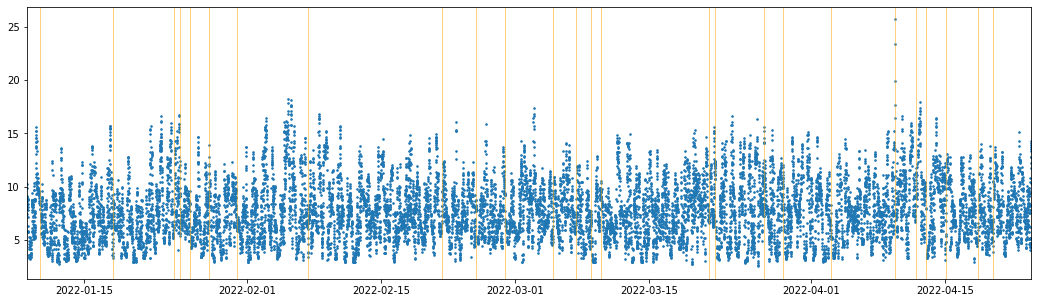

patch count: 58


In [297]:
plt.figure(figsize=(18, 5));
patch_count = scatter_patch(df_glucose, percentile_gap, start_date, end_date);
print('patch count:', patch_count)

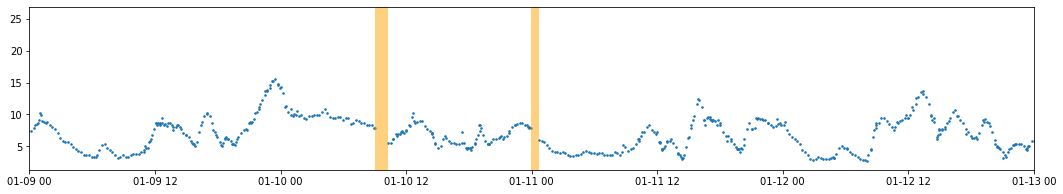

patch count: 2


In [298]:
plt.figure(figsize=(18, 3));
patch_count = scatter_patch(df_glucose, percentile_gap, start_date, pd.to_datetime('2022-01-13'));
print('patch count:', patch_count)

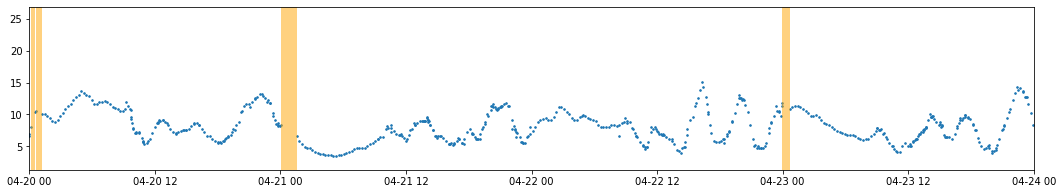

patch count: 4


In [299]:
plt.figure(figsize=(18, 3));
patch_count = scatter_patch(df_glucose, percentile_gap, pd.to_datetime('2022-04-20'), end_date);
print('patch count:', patch_count)

In [300]:
# # Get largest gaps and corresponding beginning and end timestamps
largest_gaps = time_intervals.nlargest(4)
print(largest_gaps)

dateTime
2022-02-25 02:22:00   0 days 02:52:00
2022-04-03 04:11:00   0 days 02:31:00
2022-04-18 12:05:00   0 days 02:27:00
2022-04-13 01:04:00   0 days 02:13:00
Name: dateTime, dtype: timedelta64[ns]


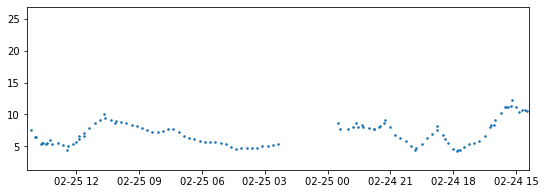

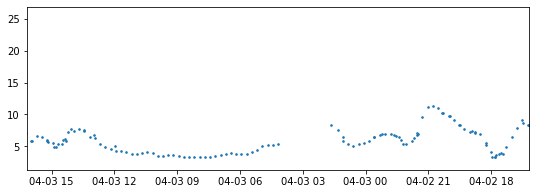

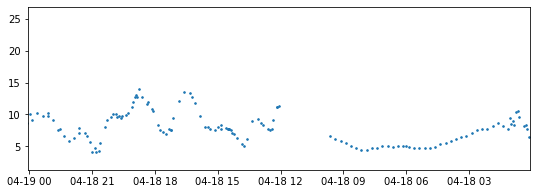

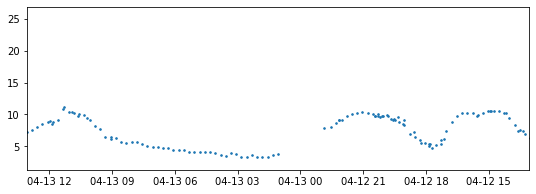

In [301]:
start = largest_gaps.index + pd.DateOffset(hours=12)
end = largest_gaps.index - pd.DateOffset(hours=12)

# TODO: FIX: why are patches not showing?
for i, gap in enumerate(largest_gaps):
    plt.figure(figsize=(9, 3));
    scatter_patch(df_glucose, percentile_gap, start[i], end[i]);

A reasonable interpolation even for the largest gaps is to draw a straight line from the last to the first data point.

#### Resample Glucose

In [302]:
# resample using 15 minute intervals, then fill in gaps using linear interpolation
df_gluc_resampled = df_glucose[['comb_gluc']].resample('15T').mean().interpolate(method='linear')
# df_gluc_resampled.index.adfreq(freq='15m')
# df_gluc_resampled.set_index(df_gluc_resampled.index).asfreq('15Min')
df_gluc_resampled.head()

,comb_gluc
dateTime,
2022-01-09 00:00:00,7.40
2022-01-09 00:15:00,7.90
2022-01-09 00:30:00,8.40
2022-01-09 00:45:00,8.85
2022-01-09 01:00:00,9.70


Check how gaps are filled

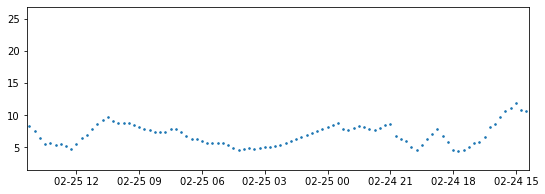

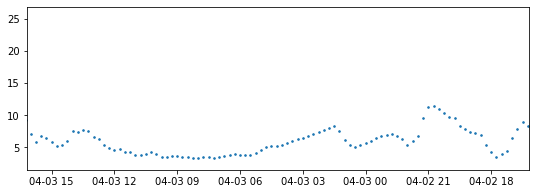

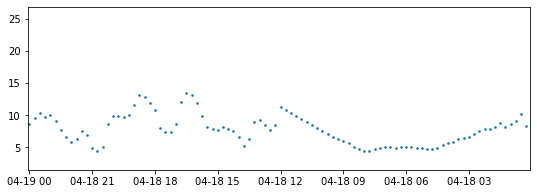

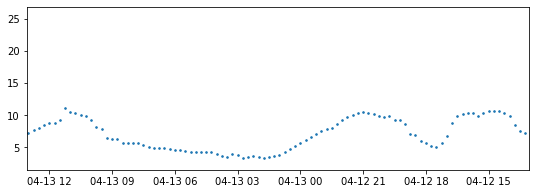

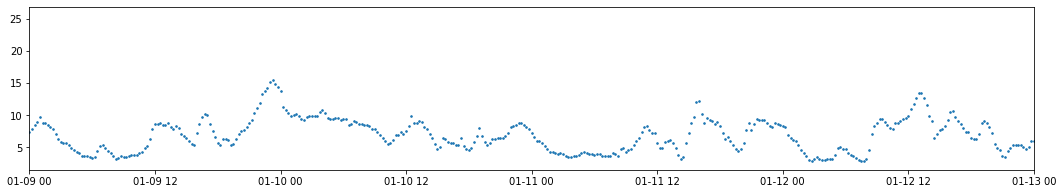

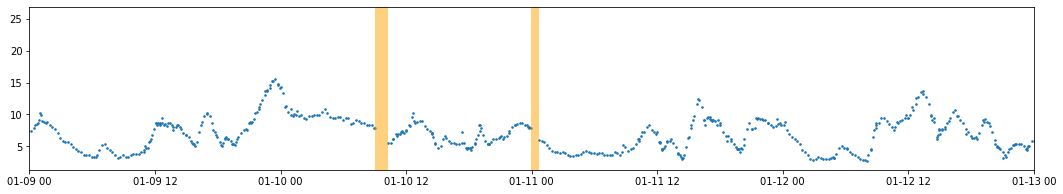

patch count: 2


In [303]:
# check how large gaps are filled in
for i, gap in enumerate(largest_gaps):
    plt.figure(figsize=(9, 3));
    scatter_patch(df_gluc_resampled, percentile_gap, start[i], end[i]);

# check how beginning is filled (no patches, since based on outdated index)
plt.figure(figsize=(18, 3));
patch_count = scatter_patch(df_gluc_resampled, percentile_gap, start_date, pd.to_datetime('2022-01-13'), patch=False);

# compare with original
plt.figure(figsize=(18, 3));
patch_count = scatter_patch(df_glucose, percentile_gap, start_date, pd.to_datetime('2022-01-13'));
print('patch count:', patch_count)

#### Check seasonality and stationarity

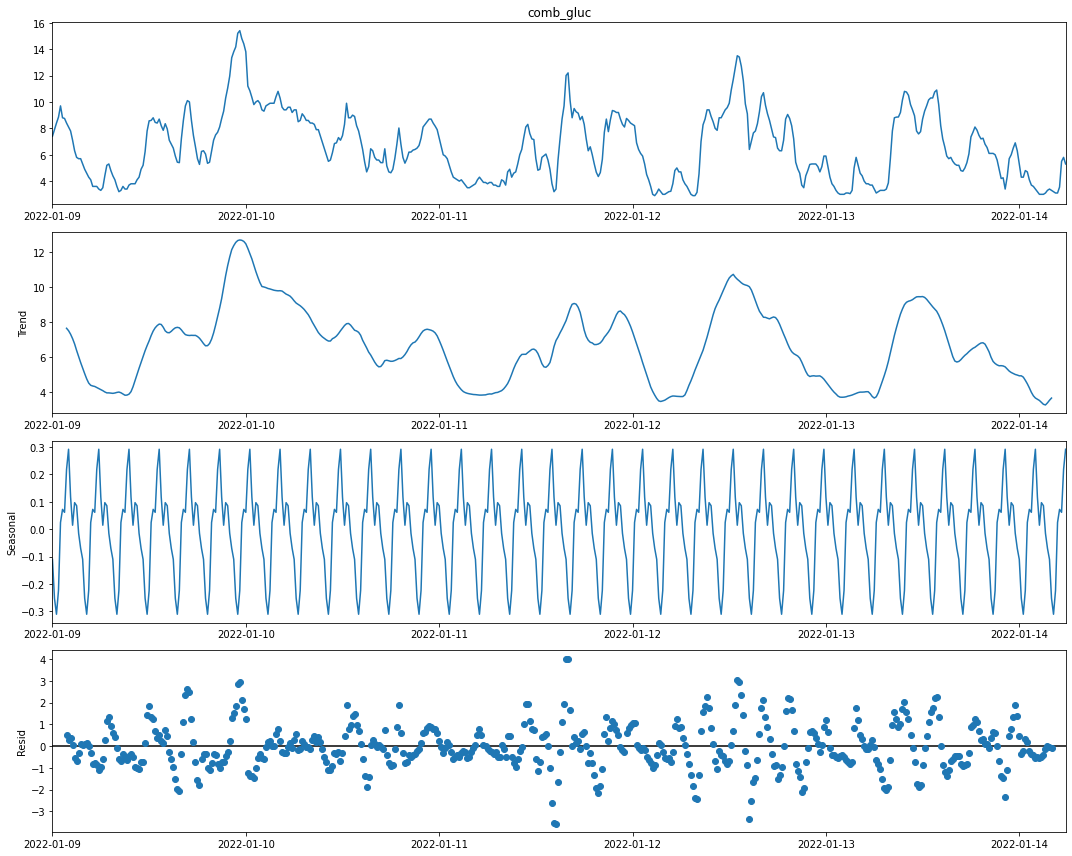

In [304]:
# check seasonality - limit time to 5 days so seasonal is not solid block
y = df_gluc_resampled.iloc[:(int(df_gluc_resampled.shape[0]/20))].comb_gluc
res = seasonal_decompose(y, period=15)
# Plot the original data, the trend, the seasonality, and the residuals 
resplot = res.plot() # seasonal=False https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.DecomposeResult.plot.html#statsmodels.tsa.seasonal.DecomposeResult.plot
resplot.set_size_inches((15, 12))
resplot.tight_layout()

Seasonal component is one order of magnitude smaller than the trend. Also, the frequency makes no sense. More likely noise than a true seasonal pattern. Residuals are comparatively large. Q: is that suspicious?

In [305]:
# check stationarity using Kwiatkowski–Phillips–Schmidt–Shin test (kpss)
'''
from SB time series case study: Null hypothesis of this test is that the time series data in question is stationary; if the p-value is less than the significance level (typically 0.05) then we reject the Null and infer that the data is not stationary.
'''
y_all = df_gluc_resampled.comb_gluc
kpss(y_all)

(0.7782114777105865,
 0.01,
 53,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [306]:
adfuller(y_all)

(-17.280449540469345,
 5.786337412731172e-30,
 19,
 10060,
 {'1%': -3.4310001957627585,
  '5%': -2.861827348038806,
  '10%': -2.5669229502211386},
 20847.871297927828)

Conclusion: data is not stationary according to kpss, but stationary according to adfuller (latter has lower p-value, which may mean stronger evidence).

Some questions:
* what to make of seasonality plot?
* will interpolation lead to data leakage when data is split if using a machine learning model?
* is an outlier still an outlier even if it's plausible? Q: should I remove it regardless if it has the potential to mess up the model, i.e., prediction may work better when outliers are removed?

Next:
* do ACF & PACF to find lag times (can be used as features in ML model)

##### ACF and PACF

Different types of models have the following behavior in the ACF and PACF:

||AR(p)|MA(q)|ARMA(p,q)|
| --- | --- | --- | --- |
|ACF|Tails off|Cuts off after lag q|Tails off|
|PACF|Cuts off after lag p|Tails off|Tails off|

ACF: auto-correlation function

PACF: partial auto-correlation function

p: number of autoregressive lags;
d: order of differencing;
q: number of moving average lags

In [307]:
# need to difference first, since data is not stationary
df_gluc_diff = df_gluc_resampled.diff().dropna()
kpss(df_gluc_diff.comb_gluc)

(0.003509162662718808,
 0.1,
 69,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [308]:
adfuller(df_gluc_diff.comb_gluc)

(-23.12559831205812,
 0.0,
 39,
 10039,
 {'1%': -3.431001556217458,
  '5%': -2.861827949213313,
  '10%': -2.5669232702269893},
 21069.447258765158)

Stationary according to kpss and adfuller, meaning the differencing order is 1 (see https://campus.datacamp.com/courses/arima-models-in-python/fitting-the-future part 2, slides pdf page 39, "Picking the difference order").

Next, plot ACF and PACF of differenced time series.

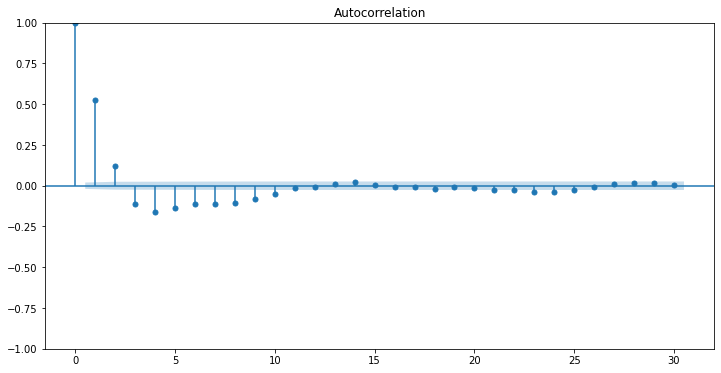

In [309]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df_gluc_diff, lags=30, ax=ax);

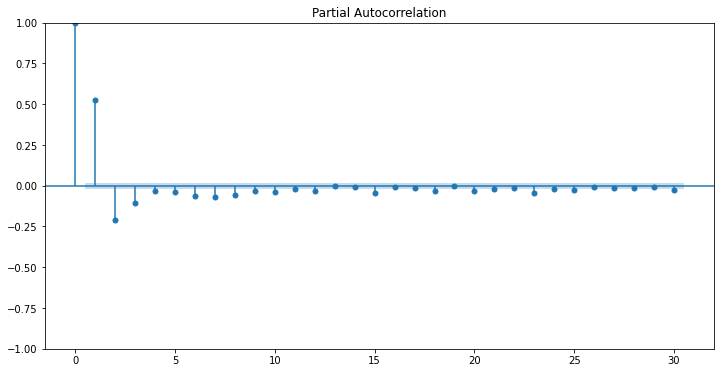

In [310]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df_gluc_diff, lags=30, ax=ax, method='ywm');

Both tail off: ARMA (not possible to see model order from plot)

##### Find best ARIMA parameters

In [311]:
# order: (p, d, q), where p is the autoregressive lag order; q is the moving 
# average lag order; d is the number of times the series has been differenced.
def get_ARIMA_mse(data, order):
     arima = ARIMA(data, order=order)
     return arima.fit().mse

# function to evaluate different ARIMA models with different p, d, and q
def eval_ARIMA_mse(data, orders):
    return [get_ARIMA_mse(data, order) for order in orders]

# choose values to try for each parameter.
# old: orders = list(itertools.product([0, 1, 2, 3, 4], repeat=3)) 
# new: iterate over wider range of p,q (limit permutations by fixing d) 
p_values = range(0, 3)
q_values = range(0, 3)
d_value = 0
orders = list(itertools.product(p_values, [d_value], q_values))

In [312]:
# find the optimum ARIMA model
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

res = eval_ARIMA_mse(df_gluc_diff, orders)

min_mse = np.min(res)
opt_order = orders[res.index(min_mse)]
print('minimum MSE is', min_mse, '\noptimal parameters p, d, q are', opt_order)

minimum MSE is 0.46991855186125997 
optimal parameters p, d, q are (2, 0, 2)


Several runs of model search using increasing values of p result in best model being that of highest p. Use elbow method instead:

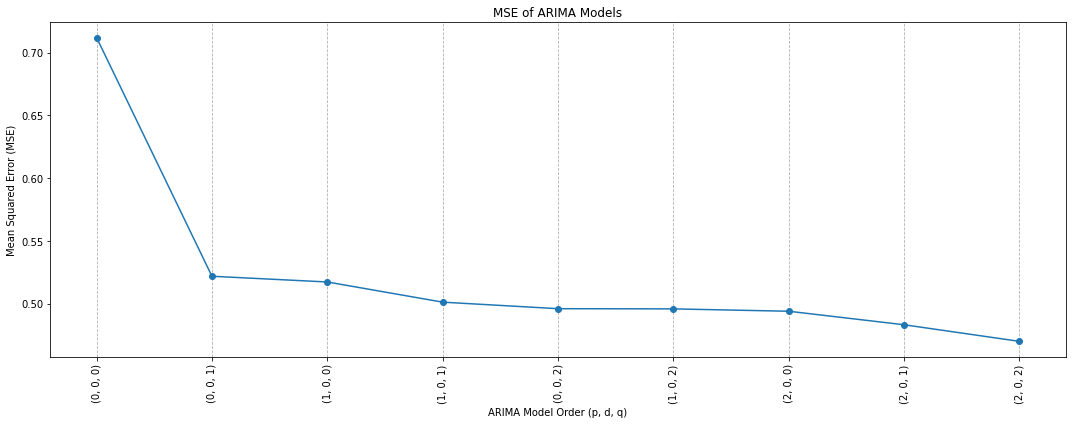

In [313]:
# plot mse in descending order, label x-axis with the order tuple (p, d, q) 
mse_list, orders = zip(*sorted(zip(res, orders), reverse=True))
plt.figure(figsize=(15, 6))
plt.plot(range(len(mse_list)), mse_list, marker='o', linestyle='-')

# Label the x-axis with the order tuple (p, d, q) from the 'orders' list
x_tick_labels = [f"({order[0]}, {order[1]}, {order[2]})" for order in orders]
# plt.xticks(range(len(mse_list)), x_tick_labels, rotation=45, ha='right')
plt.xticks(range(len(mse_list)), x_tick_labels, rotation='vertical') 

plt.xlabel('ARIMA Model Order (p, d, q)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE of ARIMA Models')
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

Two low p,q  models on low MSE end are (2, 0, 1) and (3, 0, 0)

#### ARIMA(2,1,1) Glucose Forecast

In [314]:
# limit range to match later plots
start_index = pd.to_datetime('2022-01-09 12:00:00')
end_index = pd.to_datetime('2022-04-23 20:15:00 ')

# make sure glucose runs over same index as exogenous series
endog = df_gluc_resampled.comb_gluc[(df_gluc_resampled.comb_gluc.index >= start_index) & (df_gluc_resampled.comb_gluc.index <= end_index)]

In [315]:
# note: if e.g. (2,0,1) is optimal for once differenced data, then for original data set d=1, e.g. (2, 1, 1)
# meaning of q=1: error term (residual) of one previous data point is used (averaged if multiple) to predict current data point.
# p=2: model uses past 2 values(30 mins) to predict current one
order = (2, 1, 1)
# remove the last 4 hours of data from endog for prediction
model = ARIMA(endog[:-16], order=order)
fit = model.fit()
# forecast the next 4 hours
forecast = fit.get_forecast(16)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              comb_gluc   No. Observations:                10002
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -10570.661
Date:                Wed, 11 Oct 2023   AIC                          21149.321
Time:                        14:49:17   BIC                          21178.163
Sample:                    01-09-2022   HQIC                         21159.084
                         - 04-23-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3736      0.010    133.688      0.000       1.353       1.394
ar.L2         -0.5573      0.006    -93.151      0.000      -0.569      -0.546
ma.L1         -0.8256      0.011    -74.312      0.000      -0.847      -0.804
sigma2         0.4848      0.004    117.952      0.000       0.477       0.493
===================================================================================
Ljung-Box (L1) (Q):                  17.70   Jarque-Bera (JB):              8345.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

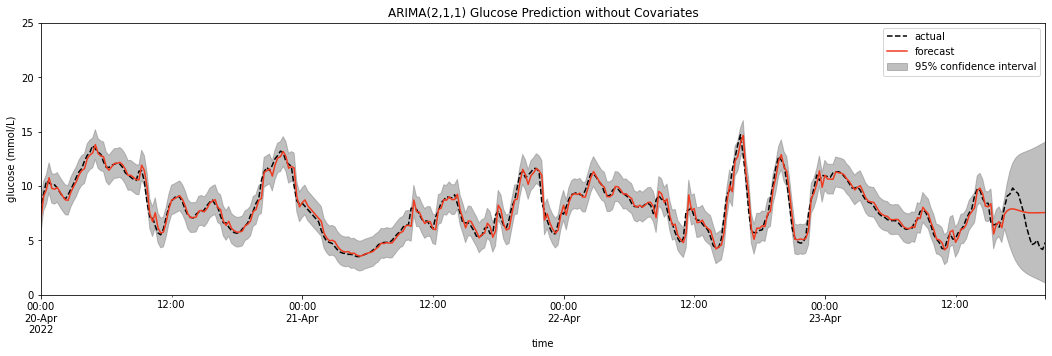

In [316]:
# set up some colors for plotting
c_actual = 'black'
c_forecast = '#f03b20'
# plot data together with model
def clean_arima_plot(ax, title):
    plt.ylim(0, 25)
    plt.xlim(pd.to_datetime('2022-04-20'), end_index)
    plt.xlabel('time')
    plt.ylabel('glucose (mmol/L)')
    # plt.gca().xaxis.set_major_locator(HourLocator(byhour=[0, 12], interval=1))
    # plt.gca().xaxis.set_minor_locator(min_locator)
    #plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
    plt.title(title)
    ax.legend(labels=['actual', 'forecast', '95% confidence interval'])

forecast_plot_size = (18, 5)

fig, ax = plt.subplots(figsize=forecast_plot_size)
# plot endog with black dash line
endog.plot(ax=ax, linestyle='--', color=c_actual)
# hack to set forecast color
ax.set_prop_cycle(color=[c_forecast])
plot_predict(fit, ax=ax, start=start_index, end=end_index);
clean_arima_plot(ax, 'ARIMA(2,1,1) Glucose Prediction without Covariates')
# save locator for TNC plots - doesn't work...
# maj_locator = ax.xaxis.get_major_locator()
# min_locator = ax.xaxis.get_minor_locator()
maj_formatter = ax.xaxis.get_major_formatter()
min_formatter = ax.xaxis.get_minor_formatter()

plt.savefig('../images/arima_forecast.png', dpi=150)
plt.show()

In [317]:
def mape_byhand(forecast, actual):
    abs_percentage_errors = abs((actual - forecast) / actual)
    mape = abs_percentage_errors.mean() * 100 
    return mape 

# get last 4 hours of endog
endog_test = endog[-16:]
mape = mape_byhand(forecast.predicted_mean , endog_test.values)
print("MAPE =", mape, "%")

MAPE = 34.305826839298994 %


##### Q: What are model's perf indicators?

MAE: 0.4761168737579655
BIC: 21178.163019241703


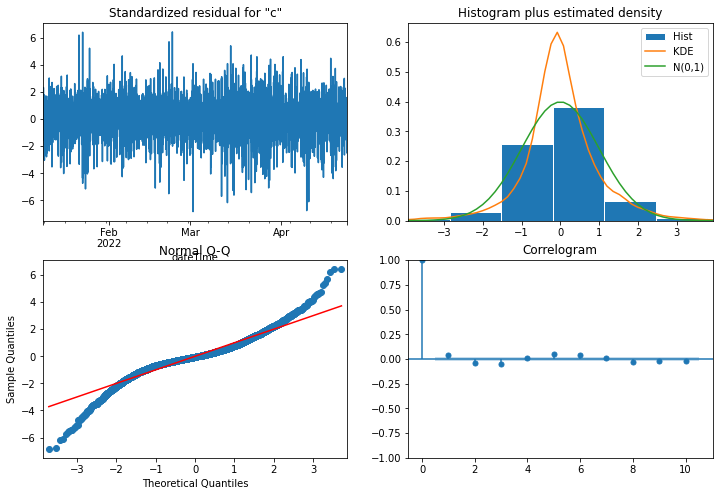

In [318]:
# mean abs error -  Q: for what, the 'in range' (one-step) prediction?
print('MAE:', fit.mae)
# BIC (see markdown below); only useful in comparison with BIC of other models
# pick lower value (better trade-off between model complexity and goodness of fit) - higher value means worse fit and/or high complexity of model
print('BIC:', fit.bic)
# look at residuals
fit.plot_diagnostics(figsize=(12,8));

Residual plot and correlogram look unsuspicious.

KDE shows that residuals are more concentrated around zero compared to normal distribution, meaning there are more residuals with small absolute values than expected, suggesting potential overfitting (from ChatGPT 3.5).

However, the normal Q-Q plot indicates this is a distribution with heavier tails, such as student's t-distribution. See https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Introductory_Statistics_(Lane)/08%3A_Advanced_Graphs/8.01%3A_Q-Q_Plots figure 8.1.12 (also, see https://www.learningtree.com/blog/interpret-q-q-plot/ t20/t3 plot for example of opposite tendency, and https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot for more examples).

While the distribution of residuals may not be exactly normal, there is no indication that it follows some other, vastly different distribution, or that the model fails to capture some of the patterns in the data.

Next:
* briefly explore remaining two data sets and add them as exog to the model

#### Clean Insulin and Carbohydrate Data

In [319]:
# df_insu_carbs & df_activity
df_insu_carbs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1759 entries, 1785 to 27
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dateTime    1759 non-null   datetime64[ns]
 1   basal_insu  103 non-null    float64       
 2   rapid_insu  530 non-null    float64       
 3   carb_grams  1214 non-null   float64       
 4   glyc_index  1214 non-null   object        
 5   meal_type   79 non-null     object        
 6   Tags        4 non-null      object        
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 109.9+ KB


In [320]:
# drop columns with little data
df_insu_carbs.drop(columns=['meal_type', 'Tags'], inplace=True)
# check for dateTime duplicate entries
print("dateTime duplicates:\n", df_insu_carbs.duplicated(subset=['dateTime'], keep=False).value_counts())

dateTime duplicates:
 False    1759
Name: count, dtype: int64


In [321]:
# set dateTime as index
df_insu_carbs.set_index('dateTime', inplace=True)

In [322]:
# set NaN in basal_insu, rapid_insu, and carb_grams to 0
# df_insu_carbs.fillna({'basal_insu': 0, 'rapid_insu': 0, 'carb_grams': 0}, inplace=True)
# df_insu_carbs.head()

In [323]:
print(df_insu_carbs.glyc_index.value_counts())
print(df_insu_carbs.glyc_index.unique())

glyc_index
Medium        597
High          265
Very High     254
Low            82
Medium          7
1               3
2               2
 Very High      1
Very High       1
3               1
High            1
Name: count, dtype: int64
['Medium' 'Very High' nan 'Low' 'High' '1' ' Very High' '2' 'Medium '
 'Very High ' '3' 'High ']


In [324]:
# unify glyc_index categories
df_insu_carbs['glyc_index'] = df_insu_carbs['glyc_index'].str.strip().str.replace(r'\s+', '_', regex=True)
# map the few numeric categories to non-numeric
df_insu_carbs['glyc_index'] = df_insu_carbs['glyc_index'].replace({'1': 'Low', '2': 'Medium', '3': 'High'})
print(df_insu_carbs.glyc_index.unique())

['Medium' 'Very_High' nan 'Low' 'High']


In [325]:
# treat basal, rapid, and carbs as three different timeseries
# GI is not its own entity but rather an attribute of carbs
# find way to combine carb and GI: GL = (GI x grams of carbohydrates) / 100
# Low GI: 55 or less, Medium GI: 56 to 69, High GI: 70 to 100
# ChatGPT doesn't find any foods with GI under 20
# use mid value + 20, use 100 for very high

# leave out for now
#df_insu_carbs['glyc_idx_num'] = df_insu_carbs.glyc_index

#### Find the best re-sample rate for insulin in carbohydrates

##### Carbohydrates over entire date range

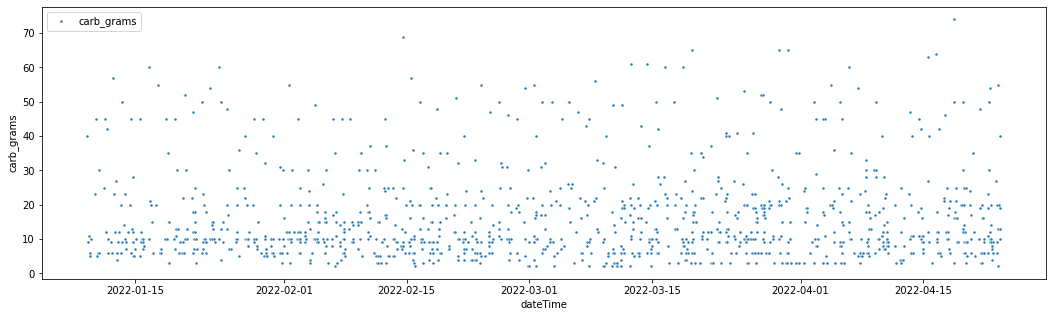

In [326]:
plt.figure(figsize=(18, 5))
sns.scatterplot(x='dateTime', y='carb_grams', data=df_insu_carbs, label='carb_grams', marker='.');

##### Look at gaps in carbohydrate data

In [327]:
# limit data to carbs only
df_carbs_only = df_insu_carbs.loc[df_insu_carbs['carb_grams'].notna(), ['carb_grams', 'glyc_index']]
df_carbs_only.head(2)

,carb_grams,glyc_index
dateTime,,
2022-01-09 12:11:29,40.0,Medium
2022-01-09 12:31:29,9.0,Very_High


In [328]:
# look at gaps - large ones are expected, so focus on small ones
df_gaps = df_carbs_only.index.to_series().diff()
df_gaps.sort_values(inplace=True)
df_gaps.head(100)

dateTime
2022-02-04 12:42:16   0 days 00:00:11
2022-03-27 12:37:31   0 days 00:00:11
2022-02-07 08:58:59   0 days 00:00:12
2022-02-22 09:21:54   0 days 00:00:19
2022-03-15 13:29:42   0 days 00:00:39
                            ...      
2022-01-17 19:10:25   0 days 00:06:56
2022-04-16 13:31:53   0 days 00:06:57
2022-03-19 14:37:38   0 days 00:06:58
2022-03-02 18:37:52   0 days 00:06:58
2022-02-07 19:23:46   0 days 00:07:04
Name: dateTime, Length: 100, dtype: timedelta64[ns]

count                         1213
mean     0 days 02:03:52.134377576
std      0 days 03:00:00.590663437
min                0 days 00:00:11
25%                0 days 00:18:49
50%                0 days 01:03:14
75%                0 days 02:17:56
max                0 days 18:57:04
Name: dateTime, dtype: object


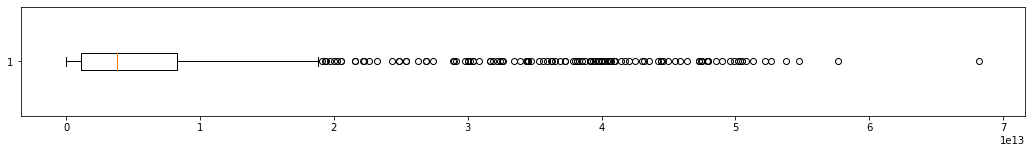

In [329]:
# get complete stats on gaps
time_intervals = df_carbs_only.index.to_series().diff().dropna()
print(time_intervals.describe())
# make box plot of all gap times
plt.figure(figsize=(18, 2))
plt.boxplot(time_intervals, vert=False, showfliers=True)
plt.show()

The intervals between meals are quite short, with a mean of about 2 hours and median of 1 hour. 

##### Zoom in around small gaps

In [330]:
# Get some small gaps and corresponding beginning and end timestamps
small_gaps = pd.concat([time_intervals.nsmallest(100).sample(3), time_intervals.nsmallest(1)])

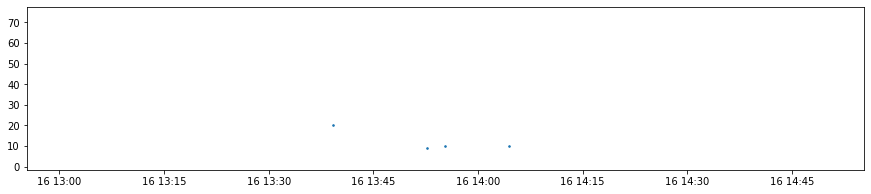

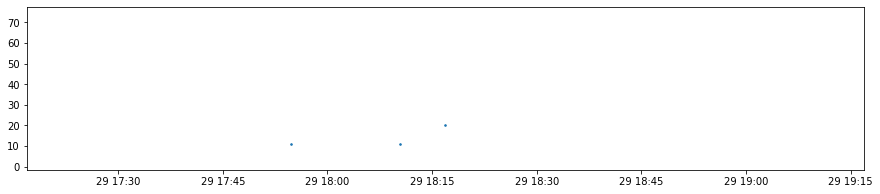

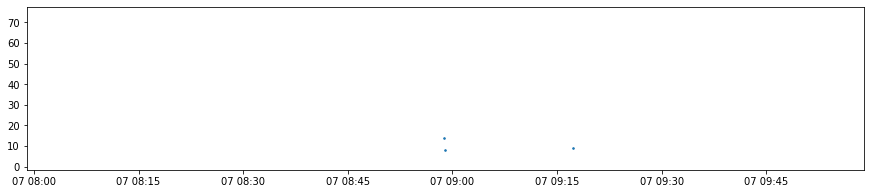

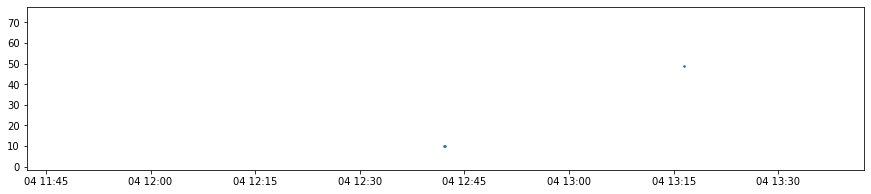

In [331]:
start = small_gaps.index - pd.DateOffset(hours=1)
end = small_gaps.index + pd.DateOffset(hours=1)

# TODO: FIX: why are patches not showing?
for i, gap in enumerate(small_gaps):
    plt.figure(figsize=(15, 3));
    scatter_patch(df_carbs_only, time_intervals.min(), start[i], end[i], column='carb_grams', patch=False);

The number of grams of carbohyrates is different for at least 3 out of 4 of these instances where there are two intakes of carbohydrates within minutes (resolution not good enough for smallest interval of 11 seconds). This more likely represents 'grazing' rather than accidental repeat entry of the same meal or snack.

A reasonable re-sampling strategy is to use 10 minute intervals with summation of the number of carbohydrates. However, Darts library requires covariates to have the same sample rate as the target series, so 15 minute intervals will be used.

##### Re-sample Carbohydrates

In [332]:
# resample using 15 minute intervals using summation
# note: would have preferred 10T to better preserve greater granularity,
# but Darts models don't support covariate series with different interval than
# target series
df_carbs_resampled = df_carbs_only[['carb_grams']].resample('15T').sum().fillna(value=0) 
# df_gluc_resampled.index.adfreq(freq='15m')
# df_gluc_resampled.set_index(df_gluc_resampled.index).asfreq('15Min')
df_carbs_resampled.head()

,carb_grams
dateTime,
2022-01-09 12:00:00,40.0
2022-01-09 12:15:00,0.0
2022-01-09 12:30:00,9.0
2022-01-09 12:45:00,0.0
2022-01-09 13:00:00,0.0


#### Re-sample Insulin

##### Rapid Insulin over entire range

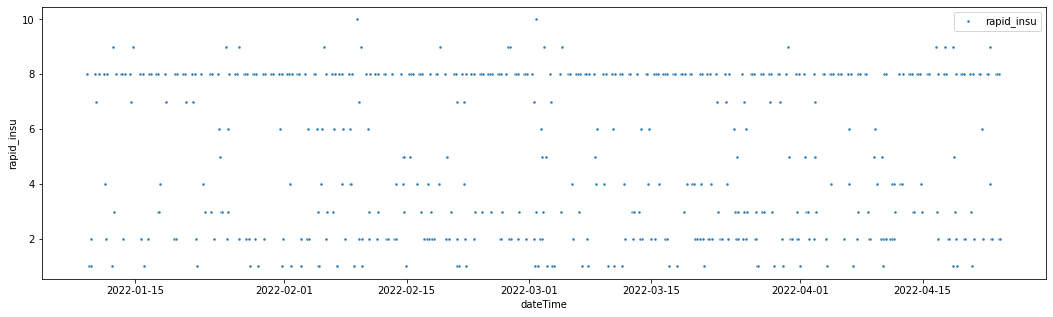

In [333]:
plt.figure(figsize=(18, 5))
sns.scatterplot(x='dateTime', y='rapid_insu', data=df_insu_carbs, label='rapid_insu', marker='.');

##### Basal Insulin over entire range

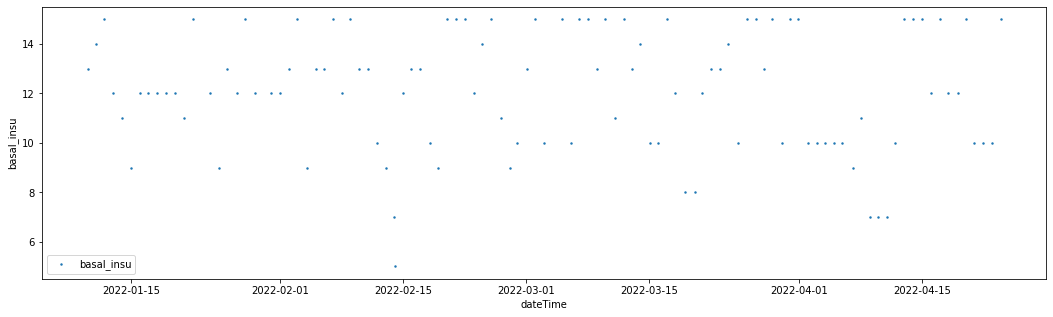

In [334]:
plt.figure(figsize=(18, 5))
sns.scatterplot(x='dateTime', y='basal_insu', data=df_insu_carbs, label='basal_insu', marker='.');

##### Zoom in (rapid & basal insulin together) with carbs and glucose level for context

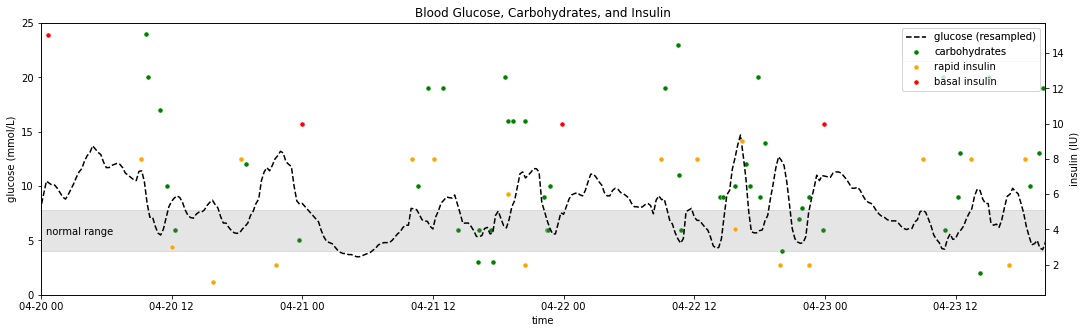

In [335]:
plt.figure(figsize=(18, 5))
ax = sns.lineplot(data=df_gluc_resampled, x='dateTime', y='comb_gluc', label='glucose (resampled)', color='black', linestyle='--')
sns.scatterplot(data=df_insu_carbs, x='dateTime', y='carb_grams', label='carbohydrates', s=25, color='green')
# make a second y-axis with different scale for insulin
ax2 = ax.twinx()
sns.scatterplot(data=df_insu_carbs, x='dateTime', y='rapid_insu', label='rapid insulin', s=25, color='orange', ax=ax2)
sns.scatterplot(data=df_insu_carbs, x='dateTime', y='basal_insu', label='basal insulin', s=25, color='red', ax=ax2)

# ax.set_xlim(start_date, pd.to_datetime('2022-01-12')) 
ax.set_xlim(pd.to_datetime('2022-04-20'), end_index)
ax.set_ylim(0,25)
ax.set_xlabel('time')
ax.set_ylabel('glucose (mmol/L)')
ax2.set_ylabel('insulin (IU)')

# get the plotted lines and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# 4 to 7.8 mmol/L (72 to 140 mg/dL) is considered normal
# add a region to the plot to highlight normal range
ax.axhspan(4, 7.8, alpha=0.2, color='grey')
# add text into the region  
ax.text(pd.to_datetime('2022-04-20 00:30:00'), 5.5, 'normal range', fontsize=10)
# add title
plt.title('Blood Glucose, Carbohydrates, and Insulin')

# save plot to file
plt.savefig('../images/insulin_carbs_glucose.png', dpi=150)
plt.show()

Person combines one daily (late night) basal insulin shot with several rapid insulin shots throughout the day that do not always match the carbohydrate intake (no consistent pre-bolus pattern). Sometimes short term insulin seems to be used to respond to present glucose levels.

In [336]:
# keep basal and rapid insulin as separate time series
# resample each by itself to 15 minutes intervals using sum
df_basal_resampled = df_insu_carbs[['basal_insu']].resample('15T').sum().fillna(value=0) 
df_rapid_resampled = df_insu_carbs[['rapid_insu']].resample('15T').sum().fillna(value=0) 
df_basal_resampled.tail(3)

,basal_insu
dateTime,
2022-04-23 22:45:00,0.0
2022-04-23 23:00:00,0.0
2022-04-23 23:15:00,15.0


In [337]:
df_rapid_resampled.tail(3)

,rapid_insu
dateTime,
2022-04-23 22:45:00,0.0
2022-04-23 23:00:00,0.0
2022-04-23 23:15:00,0.0


In [338]:
df_activity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 12 to 27
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   dateTime         106 non-null    datetime64[ns]
 1   sedentary_mins   106 non-null    int64         
 2   lightly_mins     106 non-null    int64         
 3   moderately_mins  106 non-null    int64         
 4   very_mins        106 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 5.0 KB


Store plot properties so they can be restored after Dart messes with them.

In [339]:
original_rcparams = plt.rcParams.copy()
# plt.rcParams.update(original_rcparams)

#### Darts

In [374]:
# Darts
########
# Not all Darts models can handle multiple timeseries (called Global Forecasing Models, see https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb)
# Not all models support all types of covariates (past, future)
from darts import TimeSeries as ts
from darts.models.forecasting.tcn_model import TCNModel
from darts import concatenate
from darts.metrics import mape

In [375]:
# target series and covariate series need to match exactly
# both in interval and timeframe

# full last hour is 2022-04-23 23:00:00
# full first hour is 2022-01-09 00:00:00
df_gluc_resampled.comb_gluc.tail(3)

dateTime
2022-04-23 23:15:00    12.25
2022-04-23 23:30:00    10.30
2022-04-23 23:45:00     8.30
Freq: 15T, Name: comb_gluc, dtype: float64

In [376]:
# full last hour is 2022-04-23 20:00:00  <- end index
# full first hour is 2022-01-09 13:00:00  <- start index
df_carbs_resampled.carb_grams.tail(3)

dateTime
2022-04-23 19:45:00     0.0
2022-04-23 20:00:00    19.0
2022-04-23 20:15:00    13.0
Freq: 15T, Name: carb_grams, dtype: float64

In [377]:
# Limit the Series to the specified datetime range
series_gluc = df_gluc_resampled.comb_gluc[(df_gluc_resampled.comb_gluc.index >= start_index) & (df_gluc_resampled.comb_gluc.index <= end_index)]
series_carbs = df_carbs_resampled.carb_grams[(df_carbs_resampled.carb_grams.index >= start_index) & (df_carbs_resampled.carb_grams.index <= end_index)]

In [378]:
# make Darts timeseries 
dts_gluc = ts.from_series(series_gluc)
# dts_basal = ts.from_series(df_basal_insu)
# dts_rapid = ts.from_series(df_insu_carbs.rapid_insu)
dts_carbs = ts.from_series(series_carbs)

# test/forcast last 4 hours: 16 intervals of 15 mins
train_gluc, val_gluc = dts_gluc[:-16], dts_gluc[-16:]
train_carbs, val_carbs = dts_carbs[:-16], dts_carbs[-16:]

In [379]:
# setup model parameters - note that gridsearch is for one series only https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html (there are other methods though, see https://unit8co.github.io/darts/examples/17-hyperparameter-optimization.html#One-Option:-using-gridsearch())

# number of past observations used to make a prediction: 3 days
input_chunk_length = 192 # 2 days: 192
# number of future observations to predict: 4 hours 
output_chunk_length = 16
# number of training iterations: default is 100, but train data is large
n_epochs = 5
# ensures convergence and avoids overfitting
weight_norm = False
# defaults: kernel_size=3, num_filters=3, dilation_base=2, weight_norm=False, dropout=0.2 (keep for now, later try kernel_size=5, num_filter=5, 7, 9, dropout=0.1) 
# (kernel: matrix, fundamental feature detector, such as edge; filter: combines multiple kernels for hierarchical feature extraction, such as v or u shape; kernel 5 would cover 2.5 hours instead of 1.5 hours, 3 'edge combinators' seems low for a graph with many shapes)  
kernel_size = 5
num_filters = 6 
# num_layers: automatically chosen to cover entire input chunk length, see  https://unit8co.github.io/darts/examples/05-TCN-examples.html
# more defaults: loss function MSE, optimizer Adam (adaptive, obviates learning rate), batch size 32 (number of intput and output sequences in each training pass)
# for use of likelihood, see https://unit8co.github.io/darts/examples/09-DeepTCN-examples.html

parameters = {
            "input_chunk_length": [input_chunk_length],
            "output_chunk_length": [output_chunk_length],
            "n_epochs": [n_epochs],
            "weight_norm": [weight_norm],
            "dropout": [0.1, 0.2],
            "kernel_size": [3, 5],
            "num_filters": [3, 6],
}

##### TCN Glucose Forecast without Exogenous Variables

In [380]:
tcn_model_1s =  TCNModel(
    input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length, n_epochs=n_epochs, weight_norm=weight_norm, kernel_size=kernel_size, num_filters=num_filters, random_state=42
)
tcn_model_1s.fit(series=[train_gluc], verbose=False)
forecast_1s = tcn_model_1s.predict(n=16, series=train_gluc)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 88.36it/s] 


MAPE = 31.33%


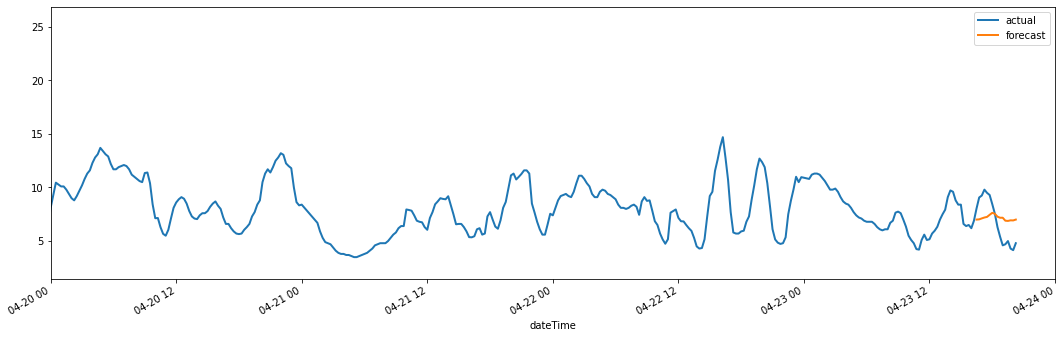

In [381]:
plt.rcParams.update(original_rcparams)
fig, ax = plt.subplots(figsize=forecast_plot_size)
dts_gluc.plot(label="actual", ax=ax)
forecast_1s.plot(label="forecast")
ax.set_xlim(pd.to_datetime('2022-04-20'), end_date)
# save plot to image file
#plt.savefig('../images/TCN_no_covars.png')
plt.legend()
print("MAPE = {:.2f}%".format(mape(dts_gluc, forecast_1s)))

##### TCN Glucose Forecast with Exogenous Carbs

In [382]:
tcn_model = TCNModel(
    input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length, n_epochs=n_epochs, weight_norm=weight_norm, kernel_size=kernel_size, num_filters=num_filters, random_state=42
)

In [383]:
# Fit the TCN model to the training data
tcn_model.fit(series=[train_gluc],
    past_covariates=[train_carbs],
    verbose=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


`Trainer.fit` stopped: `max_epochs=5` reached.


TCNModel(kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=192, output_chunk_length=16, n_epochs=5, random_state=42)

In [384]:
# Make forecasts using the TCN model
forecast = tcn_model.predict(n=16, series=train_gluc)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.83it/s]


MAPE = 33.56%


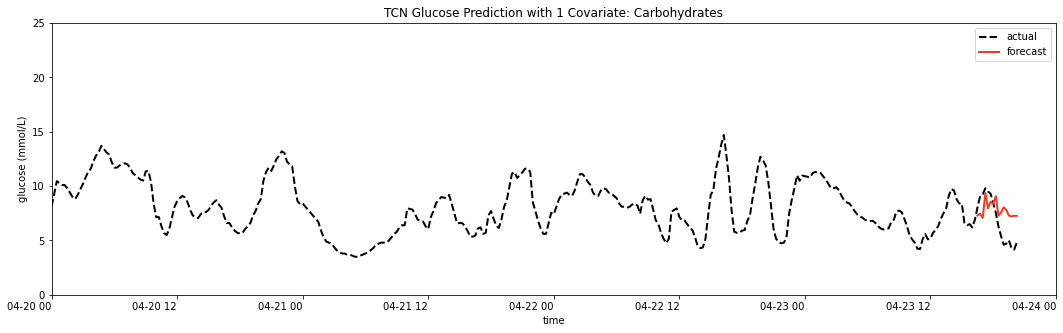

In [385]:
def clean_tcn_plot(ax, title):
    ax.set_xlim(pd.to_datetime('2022-04-20'), end_date)
    ax.set_ylim(0,25)
    plt.xlabel('time')
    plt.ylabel('glucose (mmol/L)')
    plt.legend()
    plt.title(title)
    plt.xticks(rotation=0)
    # plt.gca().xaxis.set_major_formatter(maj_formatter)
    # plt.gca().xaxis.set_minor_formatter(min_formatter)


plt.rcParams.update(original_rcparams)
fig, ax = plt.subplots(figsize=forecast_plot_size)
dts_gluc.plot(label="actual", ax=ax, linestyle='--', color=c_actual, alpha=0.8)
forecast.plot(label="forecast", color=c_forecast)
clean_tcn_plot(ax, 'TCN Glucose Prediction with 1 Covariate: Carbohydrates')    
# save plot to image file
plt.savefig('../images/TCN_1covar.png', dpi=150)
print("MAPE = {:.2f}%".format(mape(dts_gluc, forecast)))

Looks promising, but without a confidence interval, can't really tell.

Add insulin data next.

##### TCN with Carbs and Insulin

In [386]:
# adjust start & end date to match other time series
series_basal = df_basal_resampled.basal_insu[(df_basal_resampled.basal_insu.index >= start_index) & (df_basal_resampled.basal_insu.index <= end_index)]

series_rapid = df_rapid_resampled.rapid_insu[(df_rapid_resampled.rapid_insu.index >= start_index) & (df_rapid_resampled.rapid_insu.index <= end_index)]

In [387]:
# make Darts timeseries 
dts_basal = ts.from_series(series_basal)
dts_rapid = ts.from_series(series_rapid)

# test/forcast last 4 hours: 16 intervals of 15 mins
train_basal, val_basal = dts_basal[:-16], dts_basal[-16:]
train_rapid, val_rapid = dts_rapid[:-16], dts_rapid[-16:]

In [388]:
past_covariates = concatenate([train_carbs, train_basal, train_rapid], axis=1)

In [389]:
# add new series to model
# make a new model
tcn_model_4s = TCNModel(
    input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length, n_epochs=n_epochs, weight_norm=weight_norm,  kernel_size=kernel_size, num_filters=num_filters,random_state=42
    ) # weight_norm=True, num_layers=8

# note: dilation_factor for each layer is dilation_base**layer_index
# default dilatio_base is 2, so in layer 8 dilation is 256 

# Fit the TCN model to the training data
tcn_model_4s.fit(series=[train_gluc],
    past_covariates=[past_covariates],
    verbose=False)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


`Trainer.fit` stopped: `max_epochs=5` reached.


TCNModel(kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=192, output_chunk_length=16, n_epochs=5, random_state=42)

In [390]:
tcn4_forecast = tcn_model_4s.predict(n=16, series=train_gluc)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.74it/s]


MAPE = 33.74%


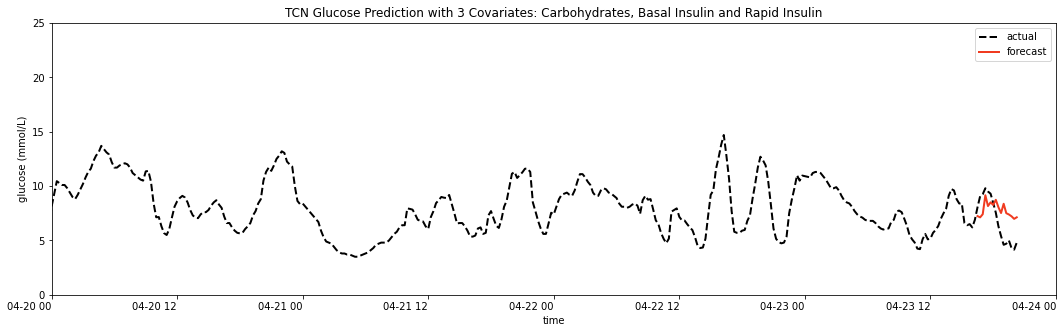

In [391]:
plt.rcParams.update(original_rcparams)
fig, ax = plt.subplots(figsize=forecast_plot_size)
dts_gluc.plot(label="actual", ax=ax, linestyle='--', color=c_actual, alpha=0.8)
tcn4_forecast.plot(label="forecast", color=c_forecast)
clean_tcn_plot(ax, 'TCN Glucose Prediction with 3 Covariates: Carbohydrates, Basal Insulin and Rapid Insulin')
plt.savefig('../images/TCN_3covars.png', dpi=150)
print("MAPE = {:.2f}%".format(mape(dts_gluc, tcn4_forecast)))

What does it mean that fit and MAPE got worse with insulin data? 

How do I prevent the model from picking up and forecasting the small jitters and instead focus on the trend within the timeframe of interest (next 4 hours)?

Says ChatGPT:
* tune hyperparams: number of layers (d:3), filters (d:10), kernel sizes (d:3), and dilations (d:[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]) - filter's kernel size defines how many neighboring input units (time intervals) the filter considers;  dilation  modifies filter's effective size by skipping certain input units, effectively increasing its receptive field -> better at capturing long-range dependencies, such as gaps between features; 4 dilations means that model samples every fourth time step in the input data
* preprocess: smoothing, filtering, or averaging 
* adjust input_chunk_length and output_chunk_length: pick multiple of 16 for input, e.g., 4*16=64, and 16 for output

Try: 
* reduce filters, increase layers
* cut off dilations above 256
* chunk: also try in 64 (16 hours) and 192 (48 hours) , out 16
* EMA: Exponential smoothing with moving average using exponentially decreasing weights for older data; useful if underlying trend changes over time - maybe not? (70% of the weight is assigned to the most recent interval, and the remaining 30% is distributed across previous intervals; overall, a few recent past intervals (approximately 3 to 4) contribute; compare ARMA(2,1) - only last two intervals)
* df['EMA'] = df['glucose'].ewm(alpha=0.3, adjust=False).mean()

Another idea: the first half of the predicted time (first 2 hours out of 4) looks half decent, so restricting the forecast to that is likely to get a much better MAPE.

##### Darts ARIMA - endogenous only

In [358]:
from darts.models import ARIMA as dARIMA
darima_model = dARIMA(p=2, d=1, q=1)
print(darima_model.supports_past_covariates, darima_model.supports_future_covariates)


from darts.models import AutoARIMA, VARIMA
auto_arima_model = AutoARIMA(p_values=[2], q_values=[1], d_value=1)
print(auto_arima_model.supports_past_covariates, auto_arima_model.supports_future_covariates)       

varima_model = VARIMA(p=2, q=1, d=1)
print(varima_model.supports_past_covariates, varima_model.supports_future_covariates)

False True
False True
False True


In [359]:
# Fit the ARIMA model with covariates; leads to error:
# TypeError: fit() got an unexpected keyword argument 'past_covariates'
# arima_model.fit(series=[train_gluc], past_covariates=[past_covariates])

In [360]:
# try Darts ARIAM with just glucose 
darima_model.fit(series=train_gluc)

ARIMA(p=2, d=1, q=1, seasonal_order=(0, 0, 0, 0), trend=None, random_state=0, add_encoders=None)

MAPE = 34.31%


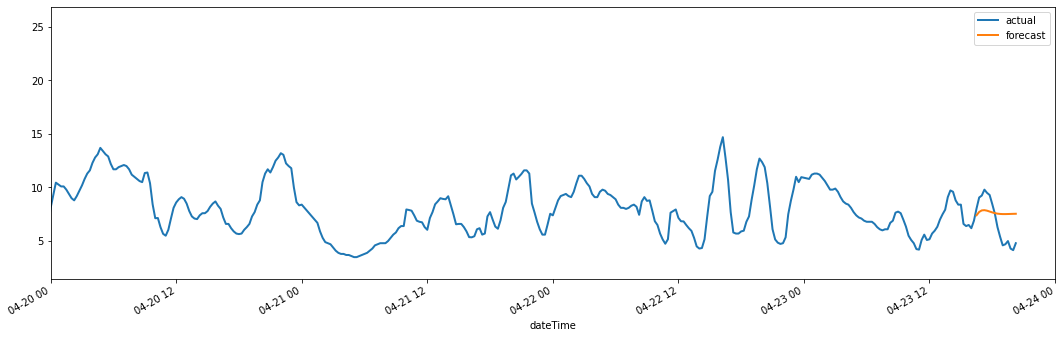

In [361]:
darima_forecast = darima_model.predict(n=16, series=train_gluc)
plt.rcParams.update(original_rcparams)
fig, ax = plt.subplots(figsize=forecast_plot_size)
dts_gluc.plot(label="actual", ax=ax)
darima_forecast.plot(label="forecast")
ax.set_xlim(pd.to_datetime('2022-04-20'), end_date)
plt.legend()
print("MAPE = {:.2f}%".format(mape(dts_gluc, darima_forecast)))

MAPE 34% vs. TCN (with carbs) MAPE  of 31%.

#### SARIMAX

In [362]:
# reset plot parameters to original
plt.rcParams.update(original_rcparams)

In [363]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Combine exogenous series
exog = pd.concat([series_carbs, series_basal, series_rapid], axis=1)

# devide exog and endog train and test data, reserving the last 16 intervals for testing
exog_train, exog_test = exog[:-16], exog[-16:]
endog_train, endog_test = endog[:-16], endog[-16:]
    

In [364]:
# define the SARIMAX model with exogenous variables
sarima_model = SARIMAX(endog=endog_train, exog=exog_train, order=order)
sarima_fit = sarima_model.fit()

# forecast the next 4 hours
forecast = sarima_fit.get_forecast(steps=16, exog=exog_test)
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              comb_gluc   No. Observations:                10002
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -10561.433
Date:                Wed, 11 Oct 2023   AIC                          21136.865
Time:                        14:55:15   BIC                          21187.338
Sample:                    01-09-2022   HQIC                         21153.950
                         - 04-23-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
carb_grams    -0.0013      0.000     -3.208      0.001      -0.002      -0.000
basal_insu     0.0085      0.003      3.072      0.002       0.003       0.014
rapid_insu     0.0072      0.002      3.150      0.002       0.003       0.012
ar.L1          1.3782      0.010    136.137      0.000       1.358       1.398
ar.L2         -0.5572      0.006    -93.469      0.000      -0.569      -0.545
ma.L1         -0.8328      0.011    -76.578      0.000      -0.854      -0.812
sigma2         0.4839      0.004    117.807      0.000       0.476       0.492
===================================================================================
Ljung-Box (L1) (Q):                  17.76   Jarque-Bera (JB):              8391.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

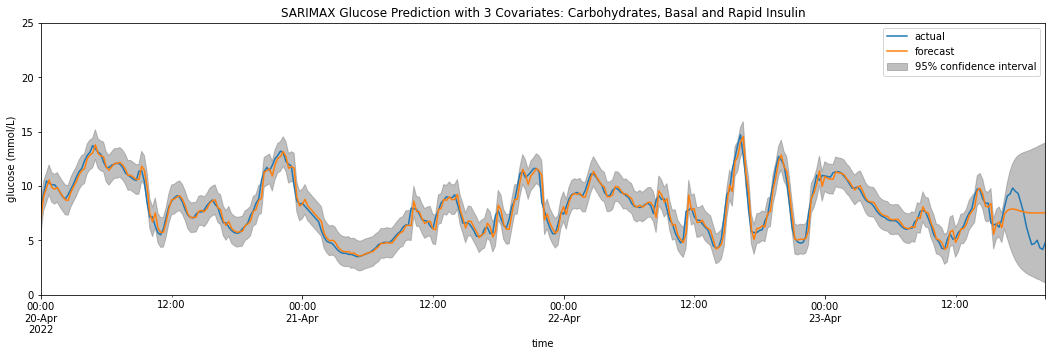

In [365]:
plt.rcParams.update(original_rcparams)
# plot predictions
fig, ax = plt.subplots(figsize=forecast_plot_size)
# df_gluc_resampled.comb_gluc.plot(ax=ax)
# use endog instead
endog.plot(ax=ax)

# get the date of the last index of the test data
end = endog_test.index[-1]
plot_predict(sarima_fit, ax=ax, end=end, exog=exog_test);
clean_arima_plot(ax, 'SARIMAX Glucose Prediction with 3 Covariates: Carbohydrates, Basal and Rapid Insulin')
plt.savefig('../images/sarimax_3covars_forecast.png')
plt.show()

In [366]:
mape = mape_byhand(forecast.predicted_mean , endog_test.values)
print("MAPE =", mape, "%")

MAPE = 34.19336495303581 %


SARIMAX MAPE 34% vs. TCN MAPE of 37% - note that TCN does not use future covariates. Also, MAPE barely improves compared to ARIMA (no covariates) and the forecast itself does not show any difference.

Next: Cleanup
* move all ARIMA/SARIMAX to top (statsmodels first, then Darts)
    - need to consolidate time series setup (timeframes for train/test)

#### Summary
* For a 4-hour blood glucose forecast, all (S)ARIMA(X) and TCN models have a MAPE of over 30%, regardless of whether covariates (carb intake, basal insulin, rapid insulin) are included or not. This error margin is too large to base any decisions on it, such as insulin amount for the next injection.
* The ARIMA plots show that the forecast diverges from the actual values very quickly. In contrast, TCN models are closer to the actual values for almost half of the forecast timeframe. However, the ARIMA models' confidence intervals (statsmodels package) point to the range of possible blood glucose values being possibly ouside of the MAPE. Darts does not seem to support confidence intervals out-of-the-box, which is problematic.

#### Future work

* Existing TNC model:
    - reduce forecast timeframe from 4 to 2 or 2.5 hours - this is still a useful prediction for a diabetic and likely reduces the MAPE
    - try increasing time interval from 15 to 30 minutes, which would reduce the number of steps the model needs to forecast for the same forecast timeframe
    - try to calculate confidence interval 'by hand'
* Other models:
    - Darts TFT (Temporal Fusion Transformer), expected to perform well in multi-horizon forecasts  (read https://arxiv.org/pdf/1912.09363.pdf), supports future and past covariates